## Initalize global variables and set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pydicom
!pip install tensorflow_addons

     |████████████████████████████████| 35.3MB 90kB/s 


In [0]:
import os
base_dir = '/content/drive/My Drive/'
dsb_dir = base_dir + 'dsb2018_topcoders/'
selim_dir = dsb_dir + 'selim/'
os.chdir(dsb_dir)
!git config --global user.email "tilacyn@yandex.ru"
!git config --global user.name "Maksim Kryuchkov"
!git add '/content/drive/My Drive/dsb2018_topcoders/selim/ipynb'
!git commit -m "updated ipynb files"
!git pull

[master ecc1503] updated ipynb files
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/tilacyn/dsb2018_topcoders
   205fbc8..f006874  master     -> origin/master
hint: Waiting for your editor to close the file... error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [4]:
import os

base_dir = '/content/drive/My Drive/'
dsb_dir = base_dir + 'dsb2018_topcoders/'
selim_dir = dsb_dir + 'selim/'

os.chdir(selim_dir)

from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
import tensorflow
import tensorflow.keras.backend as K
from datasets.lidc import LIDCDatasetIterator
from models.model_factory import make_model
from losses import make_loss
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.python.client import device_lib
from os.path import join as opjoin
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib import pyplot as plt
from models.model_factory import make_model
from datasets.lidc import imread
from os import path, mkdir, listdir
import timeit
import cv2
from tqdm import tqdm
import numpy as np
from zipfile import ZipFile
from datasets.lidc import imread, parseXML, make_mask
from train_data import MODELS_JSON, TrainData


Using TensorFlow backend.


In [0]:
gpus = [x.name for x in device_lib.list_local_devices() if x.name[:4] == '/gpu']
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4735237921275281646, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12499093364030533198
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14154465031043429172
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701401920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7085165927991039874
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

## Train the model

In [13]:
os.chdir(selim_dir)

class ModelCheckpointMGPU(ModelCheckpoint):
    def __init__(self, original_model, filepath, monitor='val_loss', verbose=0, save_best_only=False,
                 save_weights_only=False, mode='auto', period=100):
        self.original_model = original_model
        super().__init__(filepath, monitor, verbose, save_best_only, save_weights_only, mode, period)

    def on_epoch_end(self, epoch, logs=None):
        self.model = self.original_model
        super().on_epoch_end(epoch, logs)


def main(network, epochs, val_ds_len, val_steps, grid_size):
        batch_size = 16
        size = 256
        fshape = [batch_size, size, size, 3]
        sshape = [batch_size, size, size, 1]

        model = make_model('xception_fpn', (size, size, 3))

        # model = multi_gpu_model(model, 2)

        model.compile(
            loss=SigmoidFocalCrossEntropy(),
            # loss='mse',
            optimizer=Adam(lr=0.001),
        )

        # print(model.summary())

        generator = LIDCDatasetIterator(os.path.join(dsb_dir, 'data'), batch_size, val_ds_len, 1000, (size, size), grid_size)
        print(generator.n)
        print(len(generator.train_index_list))
        print(len(generator.test_index_list))
        print(len(generator.val_index_list))

        ds = tensorflow.data.Dataset.from_generator(generator.train_generator(),
                                                    (tensorflow.float32,  tensorflow.float32),
                                                    (tensorflow.TensorShape(fshape), tensorflow.TensorShape(sshape)))
        val_ds = tensorflow.data.Dataset.from_generator(generator.val_generator(),
                                                    (tensorflow.float32,  tensorflow.float32),
                                                    (tensorflow.TensorShape(fshape), tensorflow.TensorShape(sshape)))

        callbacks = [ModelCheckpoint(os.path.join(selim_dir, 'nn_models/lidc_xception_fpn_checkpoint.h5'), monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)]
        td = TrainData(network, epochs, None, None, val_ds_len, val_steps, grid_size, test_index_list=generator.test_index_list.tolist())

        model.fit(
            ds,
            epochs=epochs,
            steps_per_epoch=500,
            validation_data=val_ds,
            validation_steps=val_steps,
            # callbacks=callbacks,
            max_queue_size=5,
            verbose=1
        )

        model.save(os.path.join(selim_dir, 'nn_models/lidc_xception_fpn_final.h5'))

        td.save(model)

        return model, generator
# main('xception_fpn', 6, 200, 24, 16)
model, generator = main('xception_fpn', 15, 640, 80, 16)
# main('xception_fpn', 15, 600, 40, 16)

total len: 12226
train index array: 10586
val index array: 640
12226
10586
1000
640
Epoch 1/15
500/500 [==============================] - 619s 1s/step - loss: 0.0158 - val_loss: 0.0112
Epoch 2/15
500/500 [==============================] - 616s 1s/step - loss: 0.0097 - val_loss: 0.0076
Epoch 3/15
500/500 [==============================] - 606s 1s/step - loss: 0.0085 - val_loss: 0.0136
Epoch 4/15
500/500 [==============================] - 522s 1s/step - loss: 0.0081 - val_loss: 0.0110
Epoch 5/15
500/500 [==============================] - 532s 1s/step - loss: 0.0080 - val_loss: 0.0083
Epoch 6/15
500/500 [==============================] - 532s 1s/step - loss: 0.0072 - val_loss: 0.0098
Epoch 7/15
500/500 [==============================] - 528s 1s/step - loss: 0.0075 - val_loss: 0.0083
Epoch 8/15
500/500 [==============================] - 529s 1s/step - loss: 0.0075 - val_loss: 0.0070
Epoch 9/15
500/500 [==============================] - 528s 1s/step - loss: 0.0069 - val_loss: 0.0130
Epoch 1

In [0]:
td = TrainData('xce')

In [0]:
ds = LIDCDatasetIterator(os.path.join(dsb_dir, 'data'), 16, 100, (256, 256), 16)
gen = ds.train_generator()

NameError: ignored

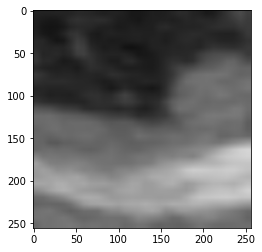

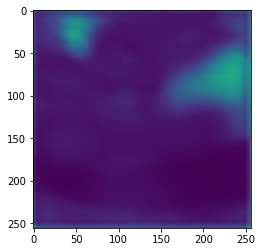

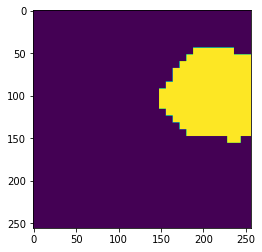

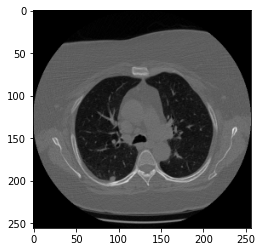

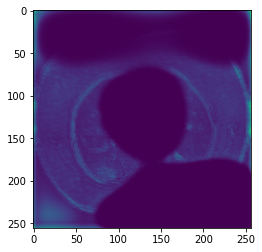

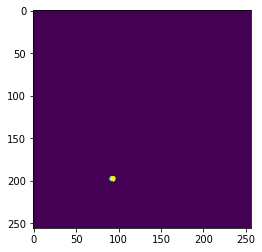

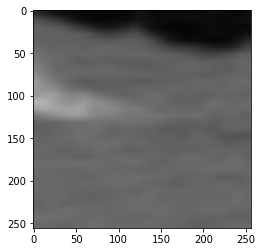

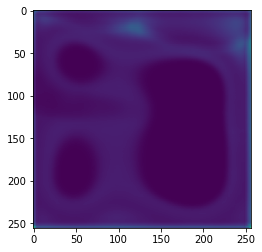

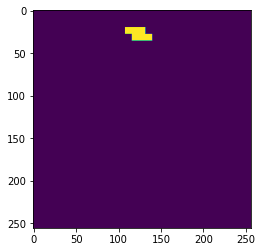

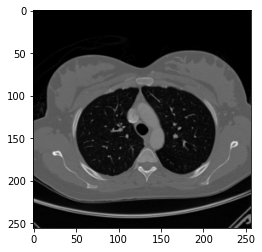

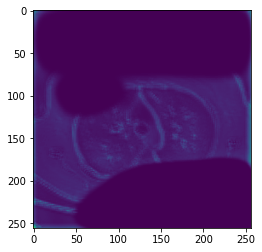

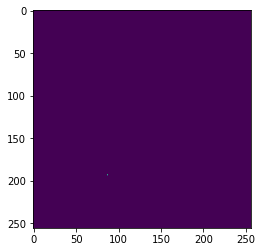

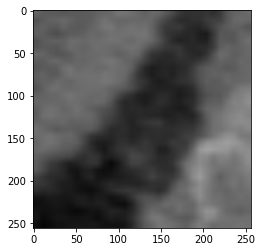

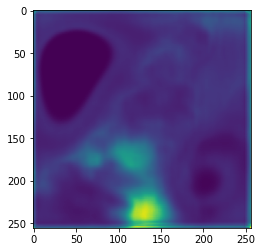

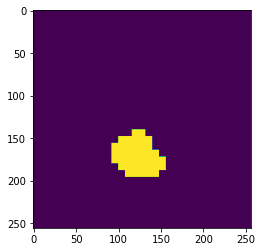

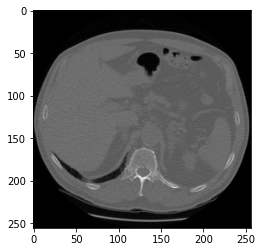

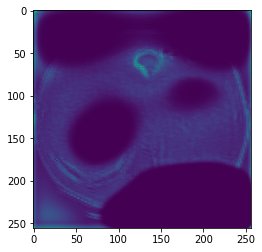

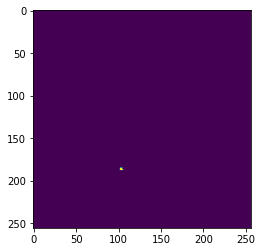

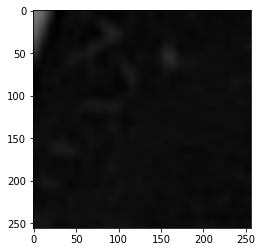

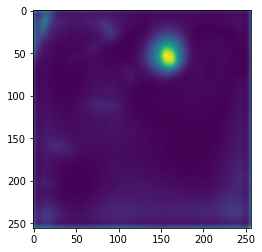

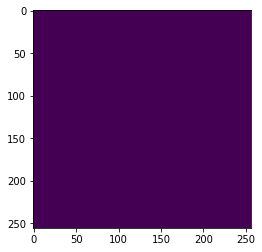

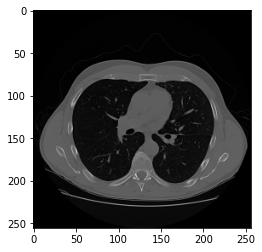

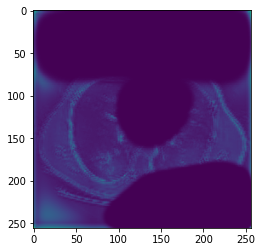

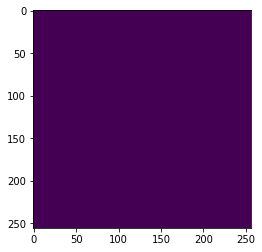

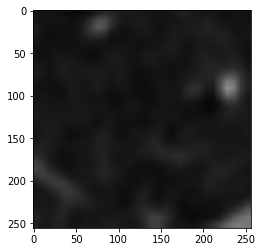

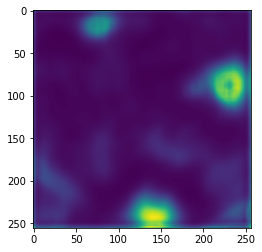

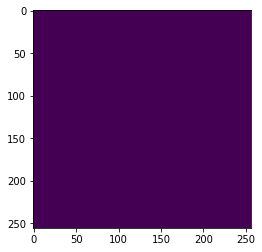

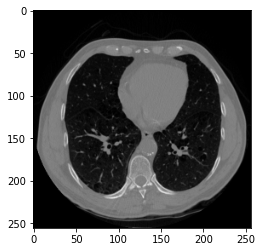

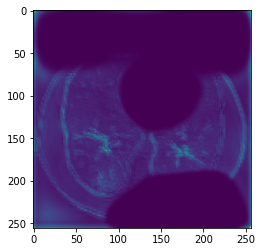

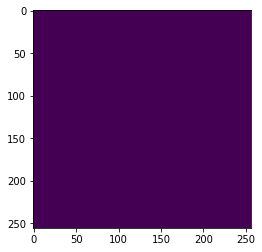

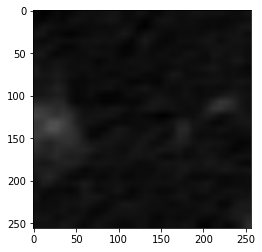

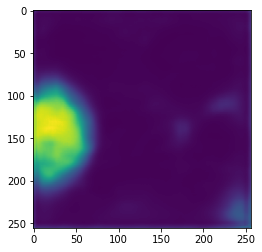

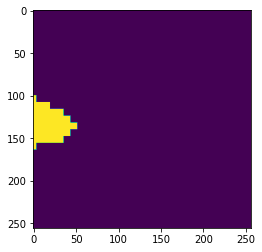

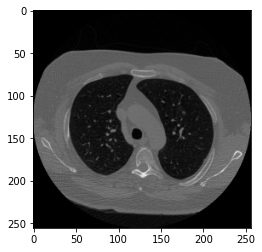

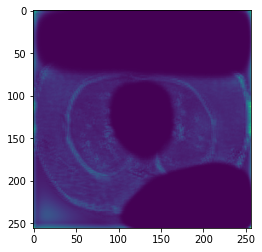

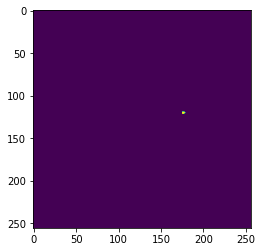

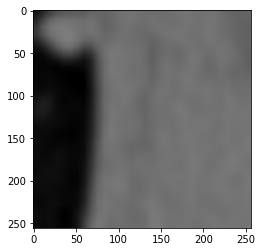

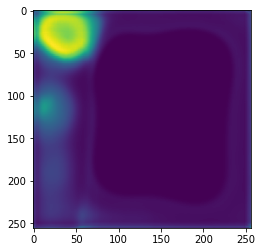

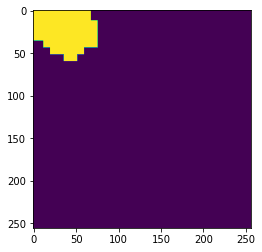

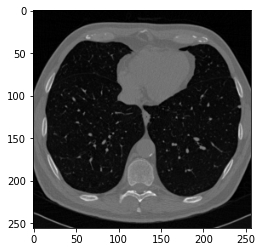

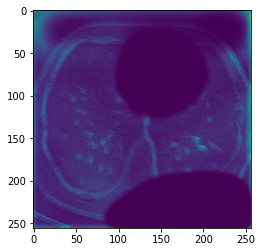

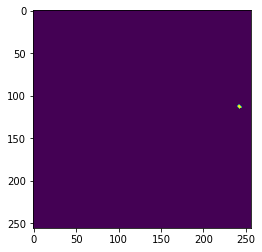

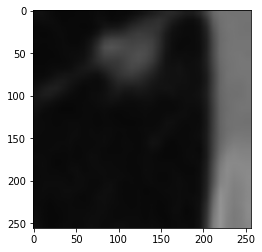

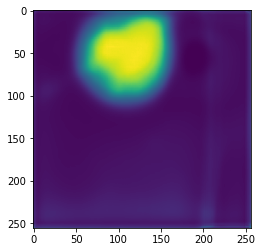

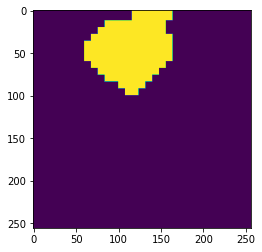

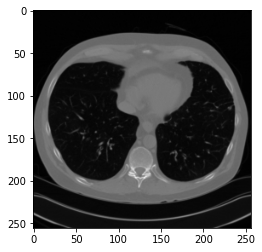

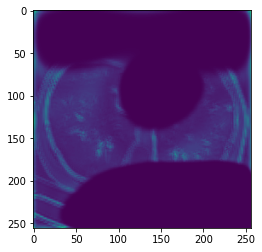

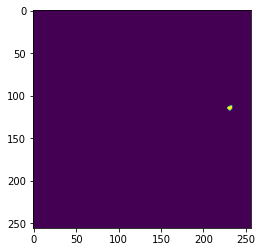

In [0]:
success = False
# batches = [next(gen()) for i in range(1)]
for batch in batches:
  x, y = batch
  pred = model.predict(x, batch_size=16)
  for i in range(len(pred)):
    expected = np.reshape(y[i], (256, 256))
    actual = np.reshape(pred[i], (256, 256))

    plt.imshow(x[i])
    plt.show()
    # print(actual.max())
    # plt.imshow(actual > actual.max() * 0.8)
    plt.imshow(actual)
    plt.show()
    plt.imshow(expected)
    plt.show()

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

def spec(y_true, y_pred):


batches = [next(gen()) for i in range(1)]
accuracies = []
for batch in batches:
  x, y = batch
  pred = model.predict(x, batch_size=16)
  for i in range(len(pred)):
    expected = np.reshape(y[i], (256, 256))
    actual = np.reshape(pred[i], (256, 256))
    actual = actual > actual.max() * 0.8
    accuracies.append(accuracy_score(expected, actual))

print(np.mean(accuracies))

NameError: ignored

* gs = 16, loss = 0.
005
* 0.0025 - xception_fpn
